<a href="https://colab.research.google.com/github/ali1810/Deep_Chem/blob/main/Solubility_Fingerprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Installation of condacolab to install rdkit ....
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
### Installing RDKIT 

!mamba install -c conda-forge rdkit

In [3]:
import pandas as pd 
import keras as k
from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Input, Dense
from keras.layers.core import Dense
#from keras.optimizer import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras import losses
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Fingerprints import FingerprintMols
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from numpy import argmax
from numpy import ndarray
import tensorflow as tf
import math
import re
import string
from collections import OrderedDict
import pandas as pd
import csv
from collections import defaultdict


In [4]:
data=pd.read_csv('/content/drive/MyDrive/KIT/delaney.csv')
data.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [5]:
smiles_array=data.SMILES

In [6]:
data["smiles_length"]= data["SMILES"].apply(len)

In [9]:
solubility_array= data.iloc[:,2]
#print(solubility_array)

In [10]:
print(len(smiles_array))
print(len(solubility_array))

1144
1144


In [11]:
#Turning SMILES into Explicit Bit Vectors (RDKit prefered format)
mols = [Chem.rdmolfiles.MolFromSmiles(SMILES_string) for SMILES_string in smiles_array]


#Convert training molecules into training fingerprints
bi = {}
fingerprints = [Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, bitInfo= bi, nBits=512) for m in mols]



In [12]:
#Convert training fingerprints into binary, and put all training binaries into arrays
import numpy as np 

fingerprints_array = []
for fingerprint in fingerprints:
        array = np.zeros((1,), dtype= int)
        DataStructs.ConvertToNumpyArray(fingerprint, array)
        fingerprints_array.append(array)

In [15]:
fingerprints_array =np.array(fingerprints_array)
solubility_array =np.array(solubility_array)

In [16]:
print(len(fingerprints_array))
print(len(solubility_array))
print(fingerprints_array.shape)
print(solubility_array.shape)

1144
1144
(1144, 512)
(1144,)


In [17]:
### Write a function to calculate these values....

def getAromaticProportion(m):
    aromatic_list = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
    aromatic = 0
    for i in aromatic_list:
        if i:
            aromatic += 1
    heavy_atom = Lipinski.HeavyAtomCount(m)
    return aromatic / heavy_atom


def generate(smiles):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = np.arange(1, 1)
    i = 0
    for mol in moldata:

        desc_MolLogP = Crippen.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Lipinski.NumRotatableBonds(mol)
        desc_AromaticProportion = getAromaticProportion(mol)
        desc_Ringcount        =   Descriptors.RingCount(mol)
        desc_TPSA = Descriptors.TPSA(mol)
        desc_Hdonrs=Lipinski.NumHDonors(mol)
        desc_SaturatedRings = Lipinski.NumSaturatedRings(mol)   
        desc_AliphaticRings = Lipinski.NumAliphaticRings(mol) 
        desc_HAcceptors = Lipinski.NumHAcceptors(mol)
        desc_Heteroatoms = Lipinski.NumHeteroatoms(mol)
        #desc_molMR=Descriptors.MolMR(mol)
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds,
                        desc_AromaticProportion,desc_Ringcount,desc_TPSA,desc_Hdonrs,desc_SaturatedRings,desc_AliphaticRings,desc_HAcceptors,desc_Heteroatoms])

        if i == 0:
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i = i + 1

    columnNames = ["MolLogP", "MolWt", "NumRotatableBonds", "AromaticProportion","Ring_Count","TPSA","H_donors","Saturated_Rings","AliphaticRings","H_Acceptors","Heteroatoms"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)

    return descriptors


In [18]:
import numpy as np
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import Crippen

In [19]:
descriptors =generate(data.SMILES)
print(descriptors)

      MolLogP    MolWt  ...  H_Acceptors  Heteroatoms
0     2.59540  167.850  ...          0.0          4.0
1     2.37650  133.405  ...          0.0          3.0
2     2.59380  167.850  ...          0.0          4.0
3     2.02890  133.405  ...          0.0          3.0
4     2.91890  187.375  ...          0.0          6.0
...       ...      ...  ...          ...          ...
1139  1.98820  287.343  ...          6.0          8.0
1140  3.42130  286.114  ...          3.0          6.0
1141  3.60960  308.333  ...          4.0          4.0
1142  2.56214  354.815  ...          4.0          8.0
1143  2.02164  179.219  ...          2.0          3.0

[1144 rows x 11 columns]


In [20]:
import numpy as np 
df1=np.array(descriptors)

#df_new=fingerprints_array.join(df1)

In [21]:
df1.shape
fingerprints_array.shape

(1144, 512)

In [22]:
### Adding two numpy array with column wise .....
df_new = np.append(fingerprints_array, df1, axis = 1)
df_new.shape

(1144, 523)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_new, solubility_array, test_size = 0.2)

In [27]:
print(X_train[0])

[-0.22206289 -0.45335813 -0.16760038 -0.12465268 -0.22206289 -0.09966832
 -0.09966832 -0.24042352 -0.19644976 10.64776972 -0.13340747 -0.18726418
 -0.08780234 -0.22475909 -0.15695878 -0.34037282 -0.15695878 -0.18411492
 -0.18726418 -0.17767127 -0.13758982 -0.12005173 -0.11527808 -0.13758982
 -0.15695878 -0.16412199 -0.09391638 -0.10511767 -0.24042352 -0.14562059
  0.         -0.14165765 -0.10511767 -1.34415344 -0.17101563 -0.16760038
 -0.4051199  -0.23786968 -0.16057632 -0.14948702 -0.11527808 -0.09391638
 -0.14948702 -0.18091815 -0.15695878 -0.18726418 -0.24295633 -0.16760038
 -0.05735393 -0.47250612 -0.23007479 -0.12005173 -0.14948702 -0.20815747
 -0.08124445 -0.11527808 -0.12909944 -0.13758982 -0.13758982 -0.09391638
 -0.04680364 -0.17101563 -0.16412199 -0.25532741  1.40728676 -0.12005173
 -0.31164451 -0.17767127 -0.17767127 -0.16057632 -0.1103093  -0.25043516
 -0.14948702 -0.21099893 -0.15695878 -0.14165765 -0.1903683  -0.15326426
 -0.14562059 -0.34633949 -0.9030372  -0.16412199 -0

In [26]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [28]:
#### Applying different Machine learning and Deep learning techique to know which works best ....
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score



In [29]:
model_svr=SVR(kernel='rbf')
model_svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [32]:
model_rf = RandomForestRegressor(n_estimators = 10000, random_state = 0)
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10000, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [33]:
model_xgr = XGBRegressor(n_estimators = 10000, random_state = 0)
model_xgr.fit(X_train, y_train)


[09:41:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

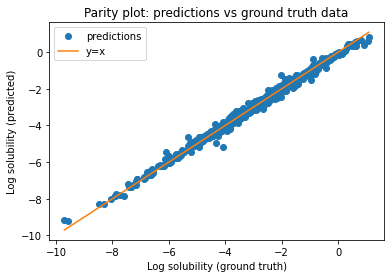

In [34]:
import matplotlib.pyplot as plt
preds = model_rf.predict(X_train)
x_y_line = np.linspace(min(y_train.flatten()), max(y_train.flatten()), 500)
plt.plot(y_train.flatten(), preds.flatten(), 'o', label='predictions')
plt.plot(x_y_line, x_y_line, label='y=x')
plt.xlabel("Log solubility (ground truth)")
plt.ylabel("Log solubility (predicted)")
plt.title("Parity plot: predictions vs ground truth data")
plt.legend()

In [35]:
Y_pred_test_rf = model_rf.predict(X_test)
res = "\n".join("{} {}".format(x, y) for x, y in zip(y_test,Y_pred_test_rf ))
#print(res)

In [36]:
from sklearn.metrics import r2_score
r2_score(y_test, Y_pred_test_rf)

0.9575759136375066

In [66]:
Y_pred_test_xg = model_xgr.predict(X_test)
res = "\n".join("{} {}".format(x, y) for x, y in zip(y_test,Y_pred_test_rf ))
#print(res)

In [38]:
from sklearn.metrics import r2_score
r2_score(y_test, Y_pred_test_xg)

0.9683027311311222

In [39]:
Y_pred_test_sv = model_svr.predict(X_test)
res = "\n".join("{} {}".format(x, y) for x, y in zip(y_test,Y_pred_test_rf ))
#print(res)

In [40]:
from sklearn.metrics import r2_score
r2_score(y_test, Y_pred_test_sv)

0.7413327698742944

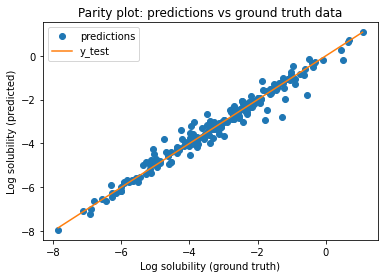

In [42]:
import matplotlib.pyplot as plt
preds = model_xgr.predict(X_test)
x_y_line = np.linspace(min(y_test.flatten()), max(y_test.flatten()), 500)
plt.plot(y_test.flatten(), preds.flatten(), 'o', label='predictions')
plt.plot(x_y_line, x_y_line, label='y_test')
plt.xlabel("Log solubility (ground truth)")
plt.ylabel("Log solubility (predicted)")
plt.title("Parity plot: predictions vs ground truth data")
plt.legend()

In [68]:
# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(523, activation = 'relu', input_dim = 523))

# Adding the second hidden layer
model.add(Dense(units = 256, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 128, activation = 'relu'))

# Adding the fourth hidden layer
model.add(Dense(units = 64, activation = 'relu'))

# Adding the fourth hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the fourth hidden layer
model.add(Dense(units = 16, activation = 'relu'))

# Adding the fourth hidden layer
model.add(Dense(units = 8, activation = 'relu'))


# Adding the output layer
model.add(Dense(units = 1))

In [69]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [70]:
model.fit(X_train, y_train, batch_size = 10, epochs = 400)

Epoch 1/400
92/92 [==============================] - 1s 4ms/step - loss: 1.6637
Epoch 2/400
92/92 [==============================] - 0s 4ms/step - loss: 0.4535
Epoch 3/400
92/92 [==============================] - 0s 4ms/step - loss: 0.2921
Epoch 4/400
92/92 [==============================] - 0s 5ms/step - loss: 0.1764
Epoch 5/400
92/92 [==============================] - 0s 4ms/step - loss: 0.1218
Epoch 6/400
92/92 [==============================] - 0s 5ms/step - loss: 0.0808
Epoch 7/400
92/92 [==============================] - 0s 4ms/step - loss: 0.0646
Epoch 8/400
92/92 [==============================] - 0s 4ms/step - loss: 0.0637
Epoch 9/400
92/92 [==============================] - 0s 4ms/step - loss: 0.0666
Epoch 10/400
92/92 [==============================] - 0s 4ms/step - loss: 0.0706
Epoch 11/400
92/92 [==============================] - 0s 5ms/step - loss: 0.0997
Epoch 12/400
92/92 [==============================] - 0s 4ms/step - loss: 0.0877
Epoch 13/400
92/92 [=================

In [71]:
Y_pred_test_ann = model.predict(X_test)
res = "\n".join("{} {}".format(x, y) for x, y in zip(y_test,Y_pred_test_rf ))
#print(res)

In [72]:
from sklearn.metrics import r2_score
r2_score(y_test, Y_pred_test_ann)

0.8879676900233026

In [73]:
# Save the model
model.save("/content/drive/MyDrive/KIT/solubility_model_88_delney.hdf5")

In [50]:
import pickle
#### Save the model :::::
#filename = 'finalized_model.rf'
pickle.dump(model_xgr, open('/content/drive/MyDrive/KIT/model_96_delnaey_512bit_descriptors.pkl', 'wb'))
 

In [1]:
### Installing RDKIT 

!mamba install -c conda-forge rdkit


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.8.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['rdkit']

conda-forge/linux-64     Using cache
conda-forge/noarch       Using cache
pkgs/main/noarc

In [2]:
from rdkit import Chem
from rdkit import Chem, DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolDescriptors

In [ ]:
#Turning SMILES into Explicit Bit Vectors (RDKit prefered format)
mols = [Chem.rdmolfiles.MolFromSmiles(SMILES_string) for SMILES_string in formated_SMILE_array]

test_mols = [Chem.rdmolfiles.MolFromSmiles(test_SMILES_string) for test_SMILES_string in test_formated_SMILE_array]

#Convert training molecules into training fingerprints
bi = {}
fingerprints = [Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, bitInfo= bi, nBits=256) for m in mols]

test_bi = {}
test_fingerprints = [rdMolDescriptors.GetMorganFingerprintAsBitVect(test_m, radius=2, bitInfo= bi, nBits=256) for test_m in test_mols]


In [ ]:
#Convert training fingerprints into binary, and put all training binaries into arrays
import numpy as np 

fingerprints_array = []
for fingerprint in fingerprints:
        array = np.zeros((1,), dtype= int)
        DataStructs.ConvertToNumpyArray(fingerprint, array)
        fingerprints_array.append(array)

test_fingerprints_array = []
for test_fingerprint in test_fingerprints:
        test_array = np.zeros((1,), dtype= int)
        DataStructs.ConvertToNumpyArray(test_fingerprint, test_array)
        test_fingerprints_array.append(test_array)

In [ ]:
### print(len(fingerprints_array))
#print(len(solubility_array))
#print(type(fingerprints_array))
#print(type(solubility_array))
#solubility_array = str(solubility_array)
#fingerprints_array= str(fingerprints_array)
#fingerprints_array=np.array(fingerprints_array)
#solubility_array=np.array(solubility_array)###
print(fingerprints_array[3])
print(solubility_array[999])

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
-3.37


In [ ]:
print(fingerprints_array.shape)
print(solubility_array.shape)

(1144, 256)
(1144,)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fingerprints_array, solubility_array, test_size=0.2, random_state=42)

In [ ]:
"""NEURAL NETWORK"""
#The neural network model
model = Sequential([
    Dense(256, input_shape=(256,), activation= "relu"),
    Dense(128, activation= "tanh"),
    Dense(64, activation= "tanh"),
    Dense(34, activation= "tanh"),
    Dense(16, activation= "tanh"),
    BatchNormalization(axis=1),
    Dense(1, activation= "tanh")
])
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_29 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 34)                2210      
_________________________________________________________________
dense_32 (Dense)             (None, 16)                560       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                

In [ ]:
#Compiling the model
#opt = .Adam(learning_rate=0.0005)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['mae'])



In [ ]:
model.fit(X_train, y_train, validation_split=0.2, batch_size=5, epochs= 200, shuffle=True, verbose=1)

Epoch 1/200
147/147 [==============================] - 1s 5ms/step - loss: 8.4050 - mae: 2.2340 - val_loss: 9.2102 - val_mae: 2.4729
Epoch 2/200
147/147 [==============================] - 1s 5ms/step - loss: 8.4063 - mae: 2.2340 - val_loss: 9.2257 - val_mae: 2.4844
Epoch 3/200
147/147 [==============================] - 1s 5ms/step - loss: 8.4052 - mae: 2.2331 - val_loss: 9.1799 - val_mae: 2.4532
Epoch 4/200
147/147 [==============================] - 1s 5ms/step - loss: 8.4053 - mae: 2.2324 - val_loss: 9.1706 - val_mae: 2.4491
Epoch 5/200
147/147 [==============================] - 1s 4ms/step - loss: 8.3999 - mae: 2.2281 - val_loss: 9.1561 - val_mae: 2.4384
Epoch 6/200
147/147 [==============================] - 1s 4ms/step - loss: 8.3992 - mae: 2.2285 - val_loss: 9.1931 - val_mae: 2.4605
Epoch 7/200
147/147 [==============================] - 1s 4ms/step - loss: 8.4052 - mae: 2.2317 - val_loss: 9.2026 - val_mae: 2.4658
Epoch 8/200
147/147 [==============================] - 1s 4ms/step - 

In [ ]:
smiles_input = Input(shape=(max_smiles_chars, charset_length), name="SMILES-Input")

In [ ]:
print(fingerprints_array)

In [ ]:
# general imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# keras imports
from keras.layers import (Input, Dense, Conv1D, MaxPool1D, Dropout, GRU, LSTM, 
                          TimeDistributed, Add, Flatten, RepeatVector, Lambda, Concatenate)
from keras.models import Model, load_model
from keras.metrics import binary_crossentropy
from keras import initializers
import keras.backend as K

# Visualization
#from keras_sequential_ascii import keras2ascii

# utils functions
#from utils import *

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Remove warnings from output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set parameters for convolutional layers 
num_conv_filters = 16
kernel_size = 3

init_weights = initializers.glorot_normal(seed=0)

# Define the convolutional layers
# Multiple convolutions in a row is a common architecture (but there are many "right" choices here)
conv_1_func = Conv1D(
    filters=num_conv_filters, # What is the "depth" of the convolution? How many times do you look at the same spot?
    kernel_size=kernel_size, # How "wide" of a spot does each filter look at?
    name="Convolution-1",
    activation="relu", # This is a common activation function: Rectified Linear Unit (ReLU)
    kernel_initializer=init_weights #This defines the initial values for the weights
)
conv_2_func = Conv1D(
    filters=num_conv_filters, 
    kernel_size=kernel_size, 
    name="Convolution-2",
    activation="relu",
    kernel_initializer=init_weights
)
conv_3_func = Conv1D(
    filters=num_conv_filters, 
    kernel_size=kernel_size, 
    name="Convolution-3",
    activation="relu",
    kernel_initializer=init_weights
)
conv_4_func = Conv1D(
    filters=num_conv_filters, 
    kernel_size=kernel_size,
    name="Convolution-4",
    activation="relu",
    kernel_initializer=init_weights
)

In [ ]:
# Define layer to flatten convolutions
flatten_func = Flatten(name="Flattened-Convolutions")

# Define the activation function layer
hidden_size = 32
dense_1_func = Dense(hidden_size, activation="relu", name="Fully-Connected", kernel_initializer=init_weights)

# Define output layer -- it's only one dimension since it is regression
output_size = 1
output_solubility_func = Dense(output_size, activation="linear", name="Log-Solubility", kernel_initializer=init_weights)

In [ ]:
smiles_input = Input(shape=(1198, 256,1), name="SMILES-Input")

In [ ]:
# connect the CNN graph together
conv_1_fwd = conv_1_func(smiles_input)
conv_2_fwd = conv_2_func(conv_1_fwd)
conv_3_fwd = conv_3_func(conv_2_fwd)
conv_4_fwd = conv_4_func(conv_3_fwd)
flattened_convs = flatten_func(conv_4_fwd)
dense_1_fwd = dense_1_func(flattened_convs)
output_solubility_fwd = output_solubility_func(flattened_convs)

ValueError: ignored

In [ ]:
# create model
solubility_model = Model(
            inputs=[smiles_input],
            outputs=[output_solubility_fwd]
)

# compile model
solubility_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

In [ ]:
from numpy import zeros, newaxis
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
#X_train = X_train[:, :, newaxis]
#X_test = X_test[:, :, newaxis]


(915, 256, 1)
(915,)
(229, 256, 1)
(229,)


In [ ]:
history = solubility_model.fit(
    X_train, # Inputs
    y_train, # Outputs
    epochs=115, # How many times to pass over the data
    batch_size=64, # How many data rows to compute at once
    verbose=1,
    validation_data=(X_test, y_test), # You would usually use more splits of the data if you plan to tune hyperparams
)

Epoch 1/115


ValueError: ignored

In [ ]:
"""NEURAL NETWORK"""
#The neural network model
model = Sequential([
    Dense(256, input_shape=(256,), activation= "relu"),
    Dense(128, activation= "tanh"),
    Dense(64, activation= "tanh"),
    Dense(34, activation= "tanh"),
    Dense(16, activation= "tanh"),
    BatchNormalization(axis=1),
    Dense(1, activation= "tanh")
])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 34)                2210      
_________________________________________________________________
dense_22 (Dense)             (None, 16)                560       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

In [ ]:
#Compiling the model
#opt = .Adam(learning_rate=0.0005)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['mae'])



In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=200,
                    batch_size=20)

Epoch 1/200
46/46 [==============================] - 0s 5ms/step - loss: 8.2140 - mae: 2.2480 - val_loss: 9.7523 - val_mae: 2.4328
Epoch 2/200
46/46 [==============================] - 0s 5ms/step - loss: 8.2146 - mae: 2.2474 - val_loss: 9.7523 - val_mae: 2.4328
Epoch 3/200
46/46 [==============================] - 0s 5ms/step - loss: 8.2146 - mae: 2.2484 - val_loss: 9.7522 - val_mae: 2.4328
Epoch 4/200
46/46 [==============================] - 0s 5ms/step - loss: 8.2143 - mae: 2.2474 - val_loss: 9.7516 - val_mae: 2.4326
Epoch 5/200
46/46 [==============================] - 0s 5ms/step - loss: 8.2147 - mae: 2.2479 - val_loss: 9.7441 - val_mae: 2.4279
Epoch 6/200
46/46 [==============================] - 0s 5ms/step - loss: 8.2132 - mae: 2.2467 - val_loss: 9.7523 - val_mae: 2.4328
Epoch 7/200
46/46 [==============================] - 0s 5ms/step - loss: 8.2152 - mae: 2.2488 - val_loss: 9.7523 - val_mae: 2.4328
Epoch 8/200
46/46 [==============================] - 0s 5ms/step - loss: 8.2145 - m

In [ ]:
predictions = model.predict(X_test, batch_size=1, verbose=1)
print(predictions)


229/229 [==============================] - 0s 1ms/step
[[-0.9991616 ]
 [-0.9998793 ]
 [-0.9998304 ]
 [-0.9985023 ]
 [-0.99983335]
 [-0.99952185]
 [-0.9998802 ]
 [-0.9998747 ]
 [-0.99987966]
 [-0.9998771 ]
 [-0.9998782 ]
 [-0.98370534]
 [-0.99988   ]
 [-0.998674  ]
 [-0.9998455 ]
 [-0.99976486]
 [-0.9997455 ]
 [-0.9997825 ]
 [-0.9998732 ]
 [-0.3420575 ]
 [-0.9998439 ]
 [-0.99986714]
 [-0.9996868 ]
 [-0.99987036]
 [-0.99986213]
 [-0.99984866]
 [-0.9978577 ]
 [-0.99961156]
 [-0.9998792 ]
 [-0.9997185 ]
 [-0.99987936]
 [-0.99987876]
 [-0.9998793 ]
 [-0.9998593 ]
 [-0.99970543]
 [-0.9998792 ]
 [-0.9998802 ]
 [-0.99987924]
 [-0.9998799 ]
 [-0.99987906]
 [-0.99986553]
 [-0.99987084]
 [-0.99987245]
 [-0.99971825]
 [-0.99988025]
 [-0.99976796]
 [-0.99987847]
 [-0.99987936]
 [-0.9998316 ]
 [-0.9998601 ]
 [-0.99986464]
 [-0.9998761 ]
 [-0.99981815]
 [-0.9998649 ]
 [-0.99988014]
 [-0.9998657 ]
 [-0.999879  ]
 [-0.9996535 ]
 [ 0.999991  ]
 [-0.9998799 ]
 [-0.9998797 ]
 [-0.99946374]
 [-0.9998796 ]


In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, predictions)

-0.9549223046823867

In [ ]:
# general imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# keras imports
from keras.layers import (Input, Dense, Conv1D, MaxPool1D, Dropout, GRU, LSTM, 
                          TimeDistributed, Add, Flatten, RepeatVector, Lambda, Concatenate)
from keras.models import Model, load_model
from keras.metrics import binary_crossentropy
from keras import initializers
import keras.backend as K

# Visualization
#from keras_sequential_ascii import keras2ascii

# utils functions
#from utils import *

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Remove warnings from output
import warnings
warnings.filterwarnings('ignore')